# Modelo competencia Kaggle




In [ ]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
#%pip install pandas==2.1.4
#%pip install lightgbm==4.4.0
%pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time

import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = '/content/DMEyF/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104
mes_test = 202106

# agregue sus semillas
#semillas = [17,19,23,29,31]
semillas = [47]



In [ ]:
data = pd.read_csv(dataset_path + dataset_file)

<ipython-input-5-0e2cf70132ef>:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path + dataset_file)


In [ ]:
data.shape

(981946, 179)

In [ ]:
#DATA QUALITY
#elimino las 17 columnas que tienen mas del 98 % de datos en cero que correspondan a montos y cantidaddes
data.drop(columns=['mcuenta_corriente_adicional', 'cprestamos_prendarios','cprestamos_prendarios','mprestamos_prendarios','cprestamos_hipotecarios','mprestamos_hipotecarios','mplazo_fijo_pesos','minversion1_dolares','mpayroll2','cpayroll2_trx','cpagodeservicios','mpagodeservicios','cforex_buy','mforex_buy','ccheques_depositados_rechazados','mcheques_depositados_rechazados','ccheques_emitidos_rechazados','mcheques_emitidos_rechazados'], inplace=True)


In [ ]:
data.shape

(981946, 162)

Asignar pesos a las clases.

In [ ]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

sumar la clase **BAJA+1**, que es estructuralmente muy similar a **BAJA+2**, para aumentar los casos positivos.

In [ ]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [ ]:
train_data = data[data['foto_mes'] == mes_train]
test_data = data[data['foto_mes'] == mes_test]

X_train = train_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = train_data['clase_binaria1']
y_train_binaria2 = train_data['clase_binaria2']
w_train = train_data['clase_peso']

X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_test_binaria1 = test_data['clase_binaria1']
y_test_class = test_data['clase_ternaria']
w_test = test_data['clase_peso']

Para evaluar la calidad del modelo, crear la función de evaluación que calcule la ganancia. La razón de incluir los pesos es precisamente para poder implementar esta función de evaluación de manera adecuada. Al combinar las clases *BAJA+1* y *BAJA+2* en una sola, necesitamos una forma de diferenciarlas, y es aquí donde entra en juego el *weight*. Este parámetro nos permitirá distinguir entre ambas clases al momento de evaluarlas dentro del algoritmo.


In [ ]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

# Parámetros del modelos.
params = {
    'objective': 'binary',
    'metric': 'gan_eval',
    'boosting_type': 'gbdt',
    'max_bin': 31,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.3,
    'bagging_fraction': 0.7,
    'verbose': 0
}

LGBM necesita su propio tipo de Datasets:

In [ ]:
train_data1 = lgb.Dataset(X_train, label=y_train_binaria1, weight=w_train)
train_data2 = lgb.Dataset(X_train, label=y_train_binaria2, weight=w_train)

A continuación, compararemos las dos clases. Utilizaremos para medir la calidad de las clases (y de los parámetros), la función **cv**

In [ ]:
cv_results1 = lgb.cv(
    params,
    train_data1,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

cv_results2 = lgb.cv(
    params,
    train_data2,
    num_boost_round=150,
    feval=lgb_gan_eval,
    nfold=5,
    seed=semillas[0]
)

Y vizualizamos los resultados de ambas ejecuciones:

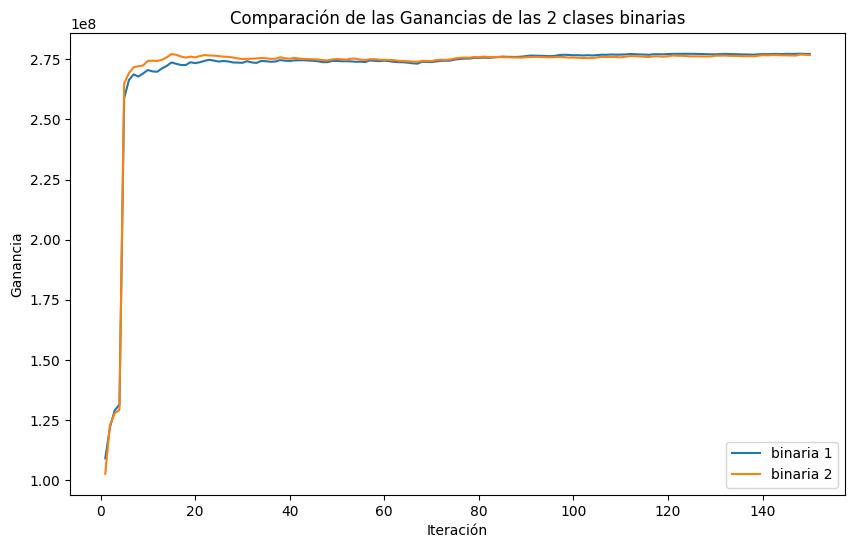

In [ ]:
df_ganancias = pd.DataFrame({
    'binaria1': cv_results1['valid gan_eval-mean'],
    'binaria2': cv_results2['valid gan_eval-mean'],
    'Iteracion': range(1, len(cv_results1['valid gan_eval-mean']) + 1)
})

# Normalizamos la ganancias
df_ganancias['binaria1'] = df_ganancias['binaria1']*5
df_ganancias['binaria2'] = df_ganancias['binaria2']*5

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteracion', y='binaria1', data=df_ganancias, label='binaria 1')
sns.lineplot(x='Iteracion', y='binaria2', data=df_ganancias, label='binaria 2')
plt.title('Comparación de las Ganancias de las 2 clases binarias')
plt.xlabel('Iteración')
plt.ylabel('Ganancia')
plt.legend()
plt.show()


Se observa una ligera mejora al combinar las clases en modelos sencillos.

Optimizar **LightGBM** utilizando la librería **Optuna**.


In [ ]:

def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 100),
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.3), # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 1000),
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0),
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': semillas[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train_binaria2, # eligir la clase
                              weight=w_train)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=400, # modificar, subit y subir... y descomentar la línea inferior
        #early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=semillas[0]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm1.db"
study_name = "exp_1_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-13 02:22:59,253] Using an existing study with name 'exp_1_lgbm' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=200) # subir subir

[I 2024-10-13 02:27:03,092] Trial 2 finished with value: 282849000.0 and parameters: {'num_leaves': 79, 'learning_rate': 0.021198629179070033, 'min_data_in_leaf': 487, 'feature_fraction': 0.5188967529525713, 'bagging_fraction': 0.3771682090340528}. Best is trial 2 with value: 282849000.0.
[I 2024-10-13 02:29:07,558] Trial 3 finished with value: 280476000.0 and parameters: {'num_leaves': 16, 'learning_rate': 0.13726247575799605, 'min_data_in_leaf': 986, 'feature_fraction': 0.6142401725562054, 'bagging_fraction': 0.8022558695863861}. Best is trial 2 with value: 282849000.0.
[I 2024-10-13 02:32:32,060] Trial 4 finished with value: 276640000.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.2919222304294823, 'min_data_in_leaf': 493, 'feature_fraction': 0.3318439404894277, 'bagging_fraction': 0.9351790174781266}. Best is trial 2 with value: 282849000.0.
[I 2024-10-13 02:35:30,772] Trial 5 finished with value: 280882000.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.1183270860

Analizamos los resultados as usual

Y finalmente tomamos el mejor modelo y lo entrenamos con la totalidad de los datos

In [ ]:
#200
study.best_trial.params

{'num_leaves': 54,
 'learning_rate': 0.046515792335640585,
 'min_data_in_leaf': 243,
 'feature_fraction': 0.5706454442625645,
 'bagging_fraction': 0.28865672170132395}

In [ ]:
best_iter = study.best_trial.user_attrs["best_iter"]
print(f"Mejor cantidad de árboles para el mejor model {best_iter}")
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'first_metric_only': True,
    'boost_from_average': True,
    'feature_pre_filter': False,
    'max_bin': 31,
    'num_leaves': study.best_trial.params['num_leaves'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'min_data_in_leaf': study.best_trial.params['min_data_in_leaf'],
    'feature_fraction': study.best_trial.params['feature_fraction'],
    'bagging_fraction': study.best_trial.params['bagging_fraction'],
    'seed': semillas[0],
    'verbose': 0
}

train_data = lgb.Dataset(X_train,
                          label=y_train_binaria2,
                          weight=w_train)

model = lgb.train(params,
                  train_data,
                  num_boost_round=best_iter)


Mejor cantidad de árboles para el mejor model 100


Observamos la variables más importantes para el modelo:

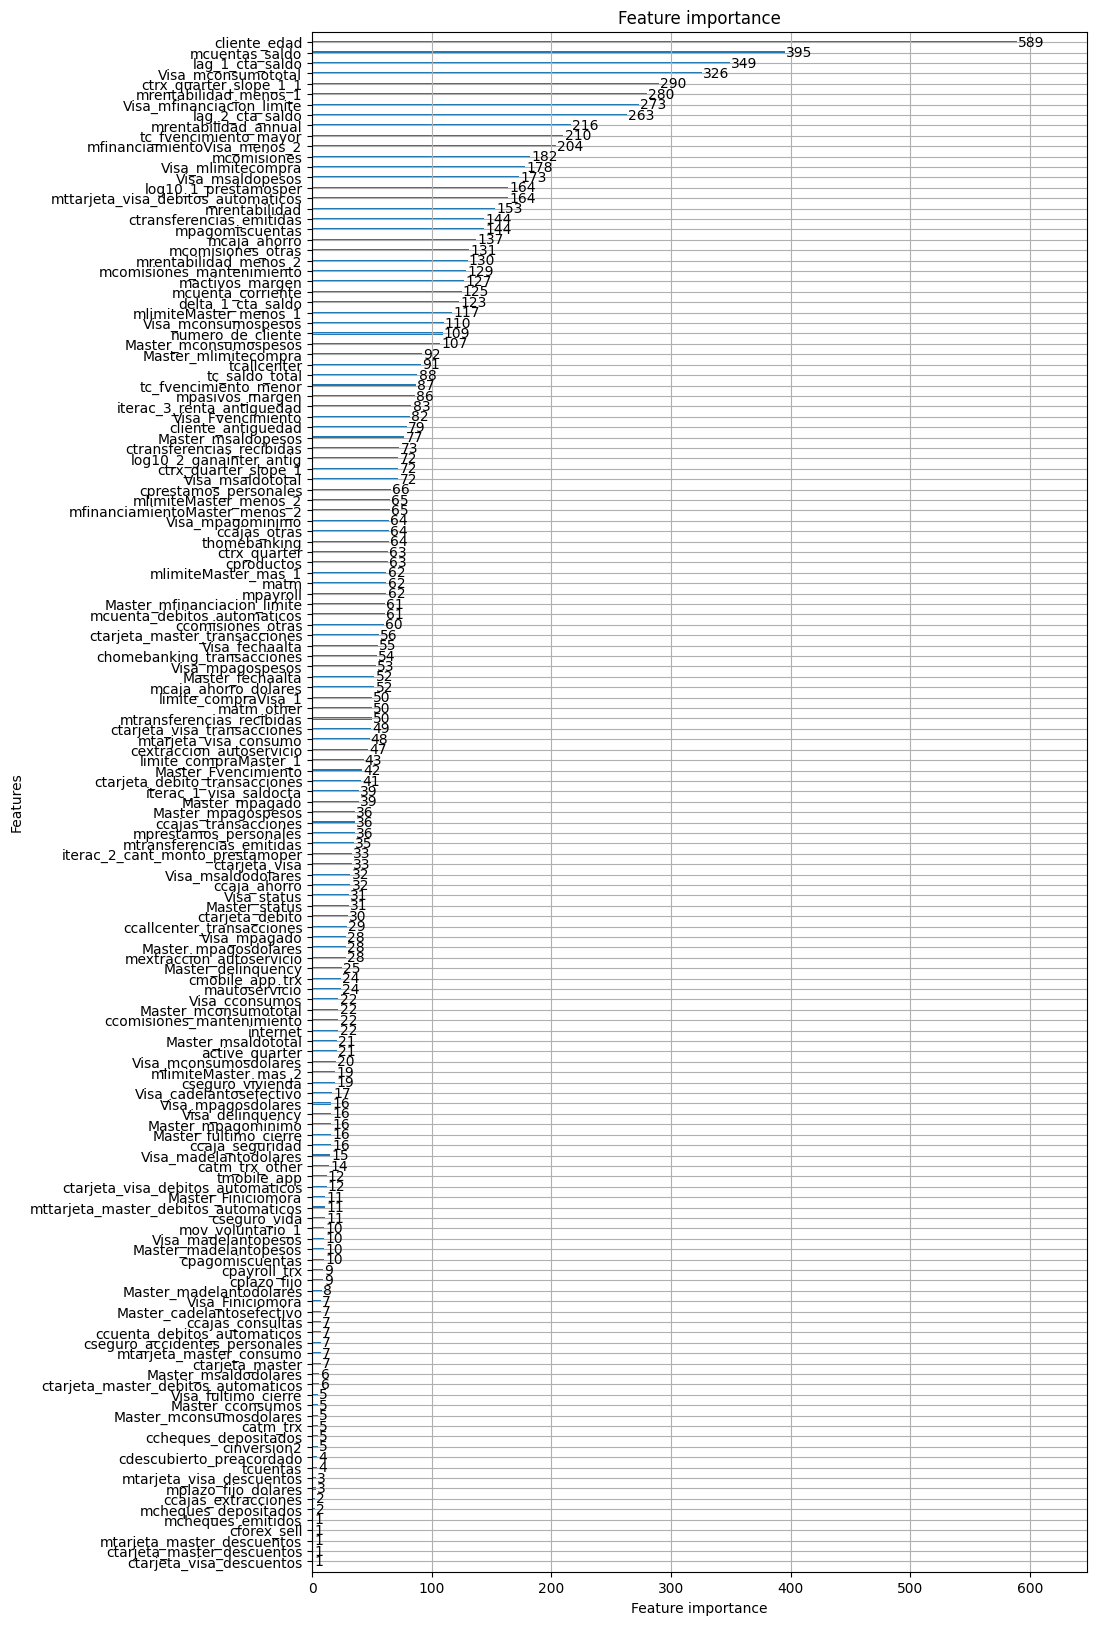

In [ ]:
lgb.plot_importance(model, figsize=(10, 20))
plt.show()


Y si queremos tener las variables más importantes en forma de *Dataframe*:

In [ ]:
importances = model.feature_importance()
feature_names = X_train.columns.tolist()
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df[importance_df['importance'] > 0]


,feature,importance
5,cliente_edad,589
21,mcuentas_saldo,395
141,lag_1_cta_saldo,349
133,Visa_mconsumototal,326
145,ctrx_quarter_slope_1_1,290
...,...,...
59,mtarjeta_master_descuentos,1
65,cforex_sell,1
58,ctarjeta_master_descuentos,1
76,mcheques_emitidos,1


In [ ]:
y_pred_lgm = model.predict(X_test)

In [ ]:
y_pred_lgm

array([0.01175046, 0.02074209, 0.01031174, ..., 0.079072  , 0.02859356,
       0.01003619])

In [ ]:
X_test['prob_baja'] = y_pred_lgm

In [ ]:
X_test['prob_baja']

,prob_baja
12288,0.011750
12289,0.020742
12290,0.010312
12291,0.013046
12292,0.045581
...,...
343047,0.008951
343048,0.012758
343049,0.079072
343050,0.028594


In [ ]:
X_test['prob_baja']= (X_test['prob_baja'] > (1 / 40)).astype(int)

In [ ]:
print(X_test[['numero_de_cliente', 'prob_baja']])

        numero_de_cliente  prob_baja
12288           944103715          0
12289           486982374          0
12290           580000985          0
12291           647637849          0
12292          1001088200          1
...                   ...        ...
343047          510189145          0
343048          510719402          0
343049          511106645          1
343050          513947149          1
343051          514157183          0

[164876 rows x 2 columns]


In [ ]:
# Seleccionar dos columnas (consulta)
resultado = X_test[['numero_de_cliente', 'prob_baja']]

# Guardar el resultado en un archivo CSV
resultado.to_csv('/content/resultado.csv', index=False)

# Descargar el archivo CSV en Google Colab
from google.colab import files
files.download('/content/resultado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>